### **About Dataset**

This dataset uses information of monthly/annual carbon dioxide emissions from electricity generation (1973-2016) provided by ***eia*** (U.S Energy Information Administration). Data is broken down by fuel type.


In [1]:
#importing libraries

import pandas as pd
import seaborn as sns
import numpy as np
import statistics  as sts
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.tsa

#additional libraries and ARIMA libraries

!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Loading database and converting date column (YYYYMM) to format Year-Month

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("/content/MER_T12_06.csv", sep=",", parse_dates=['YYYYMM'], date_parser=dateparse)
df

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLEIEUS,1973-01-01,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1,CLEIEUS,1973-02-01,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
2,CLEIEUS,1973-03-01,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
3,CLEIEUS,1973-04-01,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
4,CLEIEUS,1973-05-01,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
...,...,...,...,...,...,...
5089,TXEIEUS,2016-03-01,115.997,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5090,TXEIEUS,2016-04-01,113.815,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5091,TXEIEUS,2016-05-01,129.44,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
5092,TXEIEUS,2016-06-01,172.074,9,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [3]:
#checking data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MSN           5094 non-null   object        
 1   YYYYMM        4707 non-null   datetime64[ns]
 2   Value         5094 non-null   object        
 3   Column_Order  5094 non-null   int64         
 4   Description   5094 non-null   object        
 5   Unit          5094 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 238.9+ KB


In [4]:
#checking duplicates
df.duplicated().sum()

37

In [5]:
#checking missing data
df.isnull().sum()

MSN               0
YYYYMM          387
Value             0
Column_Order      0
Description       0
Unit              0
dtype: int64

In [6]:
#dropping duplicates and missing data
df.drop_duplicates(inplace=True)
df.dropna(inplace = True)

In [7]:
#We can see that value column is set as an object, we need to convert to a numeric value.

df['Value'] = pd.to_numeric(df['Value'] , errors='coerce')

In [9]:
#checking data again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4707 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MSN           4707 non-null   object        
 1   YYYYMM        4707 non-null   datetime64[ns]
 2   Value         4323 non-null   float64       
 3   Column_Order  4707 non-null   int64         
 4   Description   4707 non-null   object        
 5   Unit          4707 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 257.4+ KB


In [10]:
#Making a copy of the data as it is at this point to use in Power BI.
df_BI = df.copy()

In [11]:
#Using our date column to group our data
df = df.groupby(df['YYYYMM']).sum()

In [12]:
#Droping the column that won't be used in the analysis
df.drop(['Column_Order'], axis = 1, inplace = True)

In [13]:
#Checking the index
df.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01'],
              dtype='datetime64[ns]', name='YYYYMM', length=523, freq=None)

In [14]:
#We'll change the index for monthly for the time series analysis
df.index = pd.DatetimeIndex(df.index ,freq='MS')

In [15]:
df.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01'],
              dtype='datetime64[ns]', name='YYYYMM', length=523, freq='MS')

(0.0, 576.0)

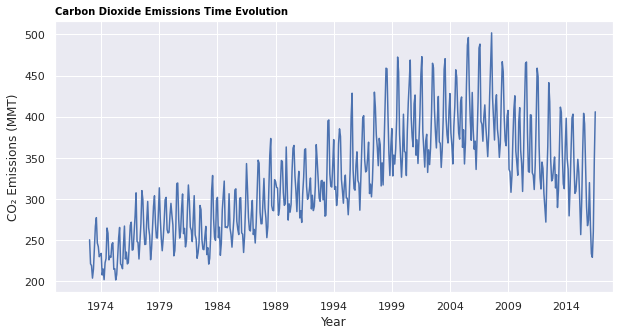

In [36]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
df['Value'].plot()
plt.title('Carbon Dioxide Emissions Time Evolution', loc = 'left', fontsize=10, fontweight='bold', color='black')
plt.xlabel("Year")
plt.ylabel("CO\u2082 Emissions (MMT)")
plt.xlim('1970', '2018')


In [24]:
#Setting the train data

TS_train = pd.Series(
    data = df.query('YYYYMM <="2010-12-31"').Value.values, 
    index = df.query('YYYYMM <="2010-12-31"').index
)

In [25]:
#Setting the test data

TS_test = pd.Series(
    data = df.query('YYYYMM>="2011-01-01"').Value.values, 
    index = df.query('YYYYMM>="2011-01-01"').index
)

(0.0, 576.0)

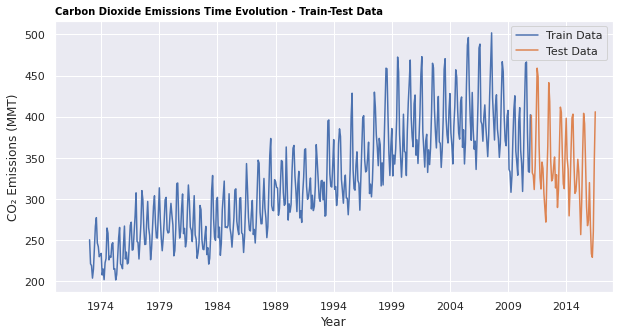

In [35]:
#Visualizing train-data data

sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
TS_train.plot()
TS_test.plot()
plt.title('Carbon Dioxide Emissions Time Evolution - Train-Test Data', loc = 'left', fontsize=10, fontweight='bold', color='black')
plt.xlabel("Year")
plt.ylabel("CO\u2082 Emissions (MMT)")
plt.legend(title='', loc='best', labels=['Train Data', 'Test Data'])
plt.xlim('1970', '2018')

In [37]:
# Using seasonal decomposition method on the train data, setting the model as additive

decomp= seasonal_decompose(
    x = TS_train, 
    model='additive', 
)

Text(0, 0.5, 'CO₂ Emissions (MMT)')

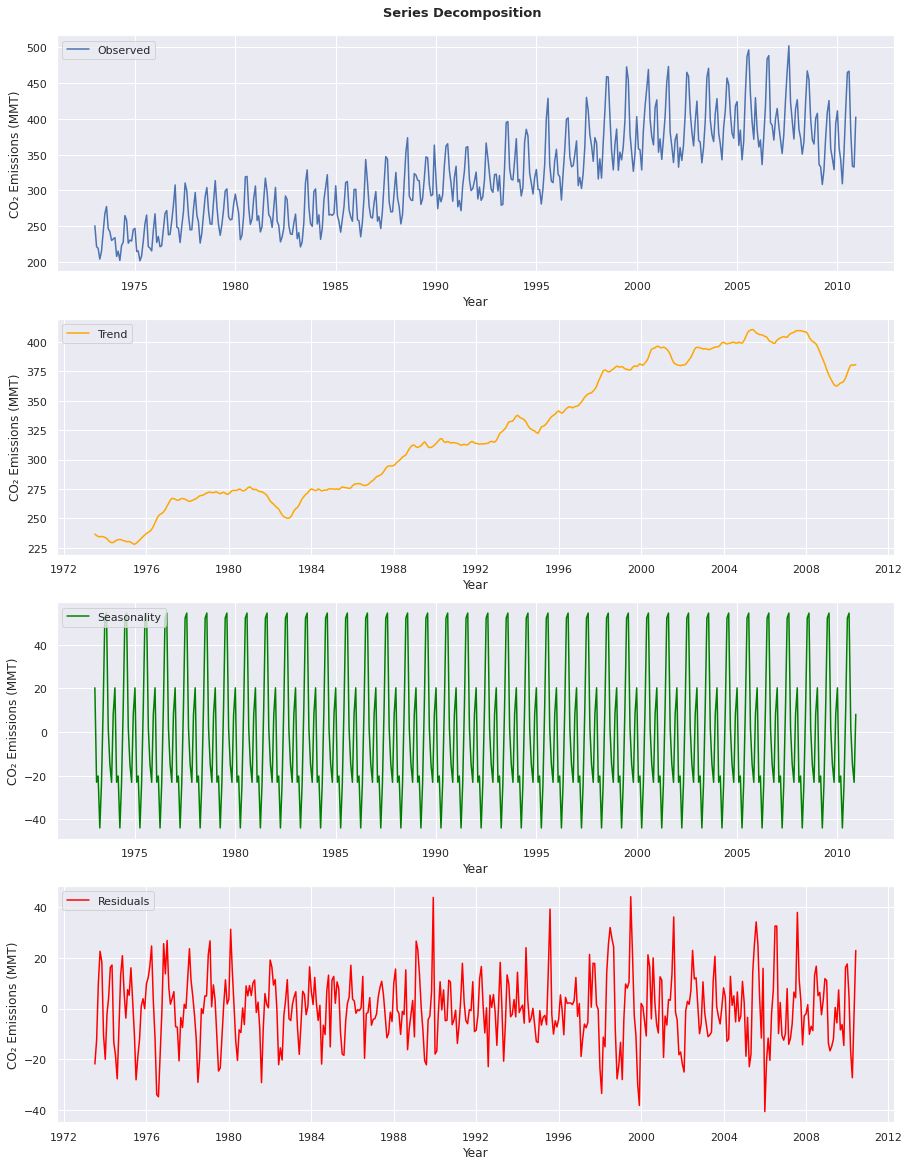

In [55]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(4, 1, figsize=(15,20))
fig.suptitle('Series Decomposition',fontsize=13, fontweight='bold', y=0.9);

#Plot 1: Observed values
axes[0].plot(decomp.observed, label = 'Observed')
axes[0].legend(loc='upper left')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("CO\u2082 Emissions (MMT)")

#Plot 2: Trend
axes[1].plot(decomp.trend, color = 'orange', label = 'Trend')
axes[1].legend(loc='upper left')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("CO\u2082 Emissions (MMT)")

#Plot 3: Seasonality
axes[2].plot(decomp.seasonal, color = 'green', label = 'Seasonality')
axes[2].legend(loc='upper left')
axes[2].set_xlabel("Year")
axes[2].set_ylabel("CO\u2082 Emissions (MMT)")

#Plot 4: Residuals
axes[3].plot(decomp.resid, color = 'red', label = 'Residuals')
axes[3].legend(loc='upper left')
axes[3].set_xlabel("Year")
axes[3].set_ylabel("CO\u2082 Emissions (MMT)")

In [56]:
#Auto-Arima model

model_autoarima = auto_arima(
    TS_train, 
    trace = True, 
    stepwise = True, 
    seasonal=True, 
    start_p=0, 
    start_d=0, 
    start_q=0, 
    start_P=0,
    start_D=0, 
    start_Q=0, 
    max_p=4,
    max_d=4, 
    max_q=4,
    max_P=4,
    max_D=4, 
    max_Q=4,
    m=12
   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4463.889, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3904.597, Time=0.66 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4218.052, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4461.937, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4456.282, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3710.291, Time=2.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4218.532, Time=0.87 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3711.621, Time=2.59 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3711.398, Time=3.03 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4111.278, Time=1.40 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3706.287, Time=7.93 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=inf, Time=18.05 sec
 ARIMA(1,1,0)(2,0,3)[12] intercept   : AIC=3707.248, Time=15.58 sec
 ARIMA(1,1,0)(1,0,3)[12] in

In [73]:
#Setting variables for the results and residuals of the model

result_autoarima    = model_autoarima.fit(TS_train)
residuals_autoarima = result_autoarima.resid

In [60]:
#Checking train sample index to see how many entries there is
TS_train.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01'],
              dtype='datetime64[ns]', name='YYYYMM', length=456, freq='MS')

In [74]:
#Using the model to predict inside the train sample

TS_model = pd.Series(
            data = result_autoarima.predict_in_sample(), 
            index = pd.date_range(start='1973-01-01', periods = 456, freq = 'MS'))

TS_model

1973-01-01      0.671856
1973-02-01    251.208424
1973-03-01    228.962752
1973-04-01    220.579186
1973-05-01    208.405606
                 ...    
2010-08-01    473.357976
2010-09-01    400.017575
2010-10-01    361.642458
2010-11-01    320.894514
2010-12-01    371.654013
Freq: MS, Name: predicted_mean, Length: 456, dtype: float64

In [62]:
TS_test

YYYYMM
2011-01-01    401.894
2011-02-01    331.911
2011-03-01    329.069
2011-04-01    311.684
2011-05-01    340.866
               ...   
2016-03-01    233.648
2016-04-01    229.324
2016-05-01    260.624
2016-06-01    345.936
2016-07-01    406.057
Freq: MS, Length: 67, dtype: float64

In [75]:
#Using the model to forecast the period of test sample

forecast_autoarima = result_autoarima.predict(n_periods=67)
forecast_autoarima

2011-01-01    404.634282
2011-02-01    357.856234
2011-03-01    355.973749
2011-04-01    328.868370
2011-05-01    359.601309
                 ...    
2016-03-01    344.962715
2016-04-01    317.391895
2016-05-01    347.591554
2016-06-01    397.197738
2016-07-01    442.605243
Freq: MS, Length: 67, dtype: float64

In [76]:
#Creating the forecast series

TS_prev = pd.Series(
          data = forecast_autoarima, 
          index = pd.date_range('2011-01-01', periods = 67, freq = 'MS'))
TS_prev

2011-01-01    404.634282
2011-02-01    357.856234
2011-03-01    355.973749
2011-04-01    328.868370
2011-05-01    359.601309
                 ...    
2016-03-01    344.962715
2016-04-01    317.391895
2016-05-01    347.591554
2016-06-01    397.197738
2016-07-01    442.605243
Freq: MS, Length: 67, dtype: float64

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normal QQ plot')

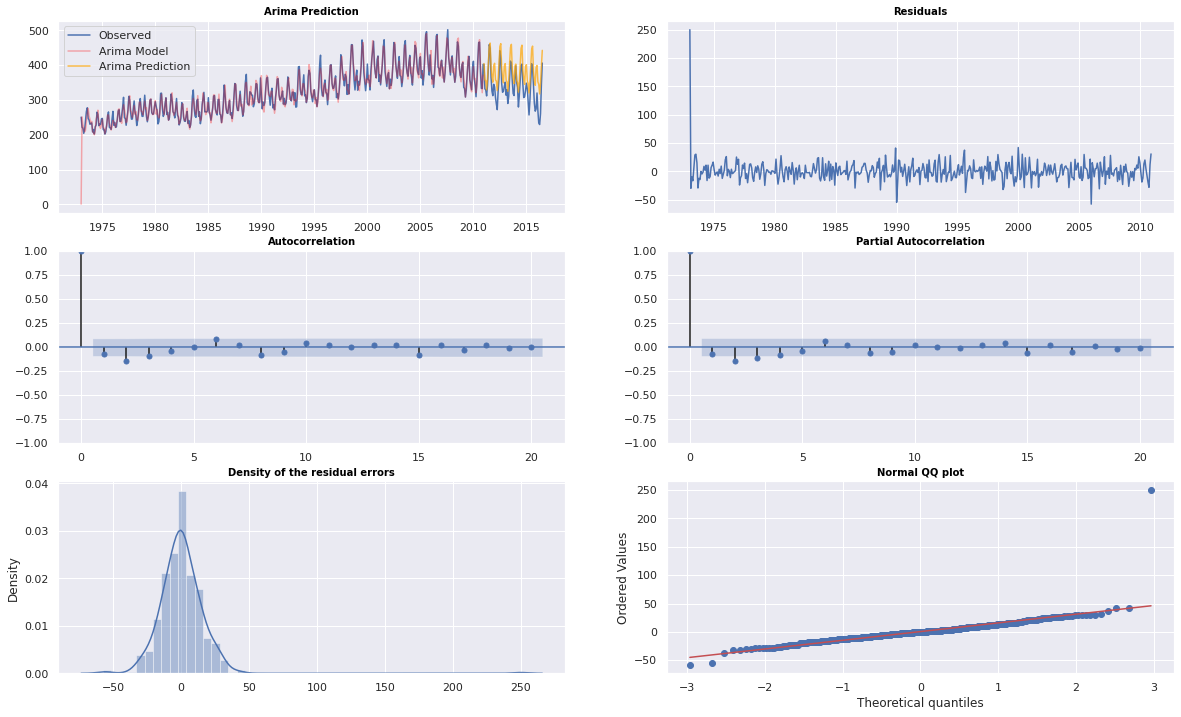

In [77]:
#Visualizing the results

sns.set(style="darkgrid")
fig, axes = plt.subplots(3, 2, figsize=(20,12))

#Plot 1: Prediction, model and observed series
axes[0][0].plot(df, label='Observed')
axes[0][0].set_title('Arima Prediction', loc = 'center', fontsize=10, fontweight='bold', color='black')
axes[0][0].plot(TS_model,color='red', label='Arima Model', alpha=0.3)
axes[0][0].plot(TS_prev,color='orange', label='Arima Prediction', alpha=0.7)
axes[0][0].legend(loc='best')


#Plot 2: Residuals
axes[0][1].set_title('Residuals', loc = 'center', fontsize=10, fontweight='bold', color='black')
axes[0][1].plot(residuals_autoarima())

#Plot 3 e 4: Autocorrelation and partial autocorrelation
plot_acf(residuals_autoarima(), lags=20, ax=axes[1][0])
axes[1][0].set_title('Autocorrelation', loc = 'center', fontsize=10, fontweight='bold', color='black')

plot_pacf(residuals_autoarima(), lags=20, ax=axes[1][1])
axes[1][1].set_title('Partial Autocorrelation', loc = 'center', fontsize=10, fontweight='bold', color='black')

#Plot 5: Density of the residual errors
axes[2][0].set_title('Density of the residual errors', loc = 'center', fontsize=10, fontweight='bold', color='black')
sns.distplot(residuals_autoarima(), ax=axes[2][0]);

#Plot 6: Normal QQ Plot
stats.probplot(residuals_autoarima(), dist="norm", plot=plt)
plt.title("Normal QQ plot", loc = 'center', fontsize=10, fontweight='bold', color='black')

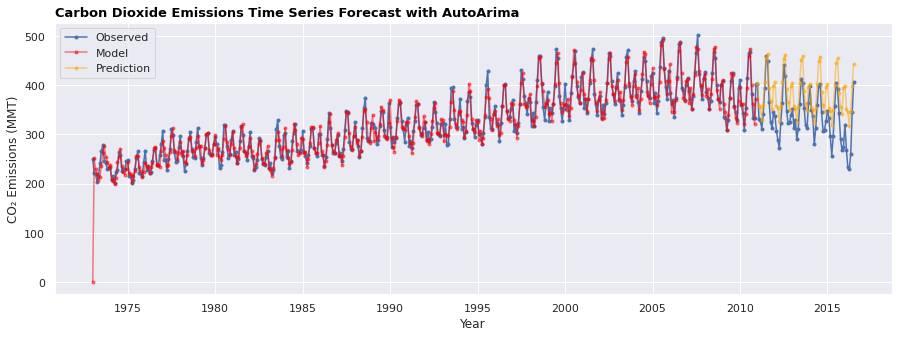

In [89]:
#Visualizing train-data data

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (15,5))
#ax.set_yscale('log')
plt.plot(df, label='Observed', marker = '.')
plt.plot(TS_model,color='red', label='Model', marker = '.', alpha=0.5)
plt.plot(TS_prev,color='orange', label='Prediction', marker = '.', alpha=0.5)
plt.title('Carbon Dioxide Emissions Time Series Forecast with AutoArima', loc = 'left', fontsize=13, fontweight='bold', color='black')
plt.xlabel("Year")
plt.ylabel("CO\u2082 Emissions (MMT)")
plt.legend(title='', loc='best')



In [90]:
#Adding new columns to dataframe to use on power BI

df['Model'] = TS_model
df['Train'] = TS_train
df['Test'] = TS_test
df['Predict'] = TS_prev 

In [92]:
#Exporting both dataframes
df.to_csv('Timeseries.csv')
df_BI.to_csv('co2_bi.csv')

In [93]:
# Libraries to compute errors 

from statsmodels.tools.eval_measures import meanabs, rmse, rmspe 

In [97]:
#Computing errors 

mae_autoarima   = meanabs(TS_test,forecast_autoarima)
rmse_autoarima  = rmse(TS_test,forecast_autoarima)
rmspe_autoarima = rmspe(TS_test,forecast_autoarima)

In [100]:
#Collecting the errors(Mean absolute error - MAE, root mean squared error - RMSE and Root Mean Squared Percentage Error - RMSPE) in a dataframe
metrics = ['MAE', 'RMSE', 'RMSPE (%)']
metrics0 = {}
metrics0['ARIMA(1,1,0)(2,0,2)'] = [round(mae_autoarima,2), round(rmse_autoarima,2), round(rmspe_autoarima,2)]
Model_metrics = pd.DataFrame(metrics0, index = metrics).T
Model_metrics

,MAE,RMSE,RMSPE (%)
"ARIMA(1,1,0)(2,0,2)",44.51,50.2,1.69
